# Add Public Raster Dataset

In [1]:
import geoengine as ge
from datetime import datetime

## Initialize Geo Engine as Admin

In [3]:
ge.initialize("http://localhost:3030", admin_token="8aca8875-425a-4ef1-8ee6-cdfc62dd7525")

## List volumes

In [4]:
volumes = ge.volumes()
volumes

[Volume(name='raid_geo_data', path='/mnt/data_raid/geo_data/'),
 Volume(name='test_data', path='test_data/'),
 Volume(name='nas_geo_data', path='/mnt/panq/dbs_research_data/geo_data/')]

## Define metadata

In [7]:
file_path = "raster/landcover/landcover.tif" # specify file path relative to volume path

rasterband_channel = 1

origin = [-180.0, 90.0]
x_pixel_size = 0.1
y_pixel_size = -0.1
geo_transform = ge.api.GdalDatasetGeoTransform({
  "originCoordinate": origin, 
  "xPixelSize": x_pixel_size, 
  "yPixelSize": y_pixel_size
})

width = 3600
height = 1800

file_not_found_handling = ge.api.FileNotFoundHandling.NODATA

gdal_params = ge.api.GdalDatasetParameters({
  "filePath": file_path, 
  "rasterbandChannel": rasterband_channel, 
  "geoTransform": geo_transform,
  "width": width, 
  "height": height , 
  "fileNotFoundHandling": file_not_found_handling, 
  "noDataValue": None, 
  "propertiesMapping": None, 
  "gdalOpenOptions": None, 
  "gdalConfigOptions": None, 
  "allowAlphabandAsMask": True
})

result_descriptor_measurement = ge.ClassificationMeasurement(
        measurement = "Land Cover",
        classes = {
          "0": "Water Bodies",
          "1": "Evergreen Needleleaf Forests",
          "2": "Evergreen Broadleaf Forests",
          "3": "Deciduous Needleleaf Forests",
          "4": "Deciduous Broadleleaf Forests",
          "5": "Mixed Forests",
          "6": "Closed Shrublands",
          "7": "Open Shrublands",
          "8": "Woody Savannas",
          "9": "Savannas",
          "10": "Grasslands",
          "11": "Permanent Wtlands",
          "12": "Croplands",
          "13": "Urban and Built-Up",
          "14": "Cropland-Natural Vegetation Mosaics",
          "15": "Snow and Ice",
          "16": "Barren or Sparsely Vegetated"
        }
      #},
      #
      #"time": {
      #  "start": "-262144-01-01T00:00:00+00:00",
      #  "end": "+262143-12-31T23:59:59.999+00:00"
      #},
      #"bbox": {
      #  "upperLeftCoordinate": [-180.0, 90.0],
      #  "lowerRightCoordinate": [180.0, -90.0]
      #},
      #"resolution": {
      #  "x": 0.1,
      #  "y": 0.1
      #}
)

result_descriptor = ge.RasterResultDescriptor("U8", result_descriptor_measurement, "EPSG:4326")

meta_data = ge.api.GdalMetaDataStatic({
  "type": "GdalStatic",
  "time": None, 
  "params": gdal_params, 
  "resultDescriptor": result_descriptor
})

meta_data

{'type': 'GdalStatic',
 'time': None,
 'params': {'filePath': 'raster/landcover/landcover.tif',
  'rasterbandChannel': 1,
  'geoTransform': {'originCoordinate': [-180.0, 90.0],
   'xPixelSize': 0.1,
   'yPixelSize': -0.1},
  'width': 3600,
  'height': 1800,
  'fileNotFoundHandling': <FileNotFoundHandling.NODATA: 'NoData'>,
  'noDataValue': None,
  'propertiesMapping': None,
  'gdalOpenOptions': None,
  'gdalConfigOptions': None,
  'allowAlphabandAsMask': True},
 'resultDescriptor': Data type:         U8
 Spatial Reference: EPSG:4326
 Measurement:       Land Cover (0: Water Bodies, 1: Evergreen Needleleaf Forests, 2: Evergreen Broadleaf Forests, 3: Deciduous Needleleaf Forests, 4: Deciduous Broadleleaf Forests, 5: Mixed Forests, 6: Closed Shrublands, 7: Open Shrublands, 8: Woody Savannas, 9: Savannas, 10: Grasslands, 11: Permanent Wtlands, 12: Croplands, 13: Urban and Built-Up, 14: Cropland-Natural Vegetation Mosaics, 15: Snow and Ice, 16: Barren or Sparsely Vegetated)}

In [8]:
add_dataset_properties = ge.AddDataset( 
    name = "Land Cover",
    source_operator = "GdalSource",
    description = "Land Cover",
    symbology = ge.RasterSymbology(
      opacity = 1.0,
      colorizer = ge.Colorizer(colorizer_type="linearGradient", breakpoints=[
        ge.ColorBreakpoint(value=0, color=(0, 0, 255, 255)),
        ge.ColorBreakpoint(value=8, color=(0, 255, 0, 255)),
        ge.ColorBreakpoint(value=16, color=(255, 0, 0, 255))
        ],
        no_data_color= (0, 0, 0, 0),
        default_color= (0, 0, 0, 0)
      )
    )

)

add_dataset_properties.to_api_dict()

{'id': None,
 'name': 'Land Cover',
 'description': 'Land Cover',
 'sourceOperator': 'GdalSource',
 'symbology': {'type': 'raster',
  'colorizer': {'type': 'linearGradient',
   'breakpoints': [{'value': 0, 'color': (0, 0, 255, 255)},
    {'value': 8, 'color': (0, 255, 0, 255)},
    {'value': 16, 'color': (255, 0, 0, 255)}],
   'noDataColor': (0, 0, 0, 0),
   'defaultColor': (0, 0, 0, 0)},
  'opacity': 1.0},
 'provenance': None}

## Add raster dataset the the first volume

In [9]:
volume = volumes[0]

dataset_id = ge.add_public_raster_dataset(volumes[0].name, add_dataset_properties, meta_data)

dataset_id

f188cf1b-ded3-4693-a07f-a7b1418e261b

## Verify that data is accessible for user

In [10]:
ge.reset()
ge.initialize("http://localhost:3030")

workflow = ge.register_workflow({
    "type": "Raster",
    "operator": {
        "type": "GdalSource",
        "params": {
            "data": {
                "type": "internal",
                "datasetId": str(dataset_id)
            },
        }
    }
})

workflow.get_result_descriptor()

Data type:         U8
Spatial Reference: EPSG:4326
Measurement:       Land Cover (0: Water Bodies, 1: Evergreen Needleleaf Forests, 10: Grasslands, 11: Permanent Wtlands, 12: Croplands, 13: Urban and Built-Up, 14: Cropland-Natural Vegetation Mosaics, 15: Snow and Ice, 16: Barren or Sparsely Vegetated, 2: Evergreen Broadleaf Forests, 3: Deciduous Needleleaf Forests, 4: Deciduous Broadleleaf Forests, 5: Mixed Forests, 6: Closed Shrublands, 7: Open Shrublands, 8: Woody Savannas, 9: Savannas)

## Load the data

/home/droenner/git/geoengine-python/env/lib/python3.10/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa


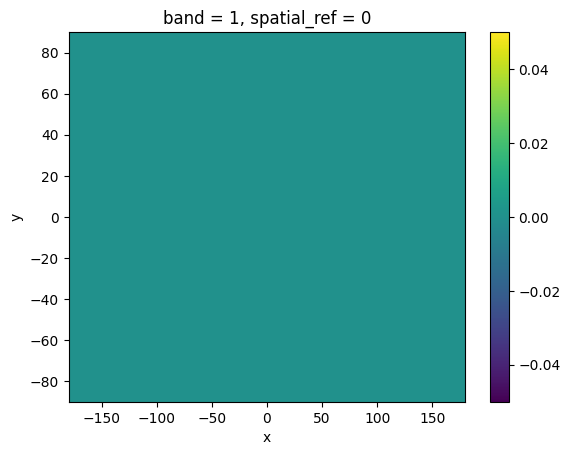

In [11]:
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

data = workflow.get_xarray(
    ge.QueryRectangle(
        [-180.0, -90.0, 180.0, 90.0],
        [time, time],
        resolution=[360. / 16, 180. / 16],
        )
)

data.plot()